# Science is Wonderful! Turn your smartphone into a 3D microscope

Code: Optical projection tomography image reconstruction from pictures taken around a (semi-)transparent object (e.g. gummy bear or marble)

Author: Teresa Correia, PhD Affiliations: Centre for Marine Sciences, CCMAR (Portugal) & Kings College London (United Kingdom) Date: August 2021

*This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No 867450.*

In [1]:
from IPython.display import clear_output
#download the data
!gdown 1SFhv11sT7vGTQqta6oZ7AmkYFHCLn295
# unzip the data
!unzip Marble.zip
#clear the output
!rm Marble.zip
clear_output()

LOAD and DISPLAY -----------------------------------------------------%% Load all files

In [2]:
import os
from PIL import Image
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon, resize
# Get list of all .png files in the current directory
files = sorted(glob.glob('Marble/*.png'))
# Sort files by modification date
files.sort(key=lambda x: os.path.getmtime(x))

# Read images and convert to grayscale
data_in = []
for file in files:
    img = Image.open(file).convert('L')  # Convert to grayscale
    data_in.append(np.array(img))

# Stack images into a 3D numpy array
data_in = np.stack(data_in, axis=-1)

# Get dimensions of the stacked array
nrows, ncols, nproj = data_in.shape

print(f"Number of rows: {nrows}, Number of columns: {ncols}, Number of projections: {nproj}")


Number of rows: 1280, Number of columns: 720, Number of projections: 72


Display projections

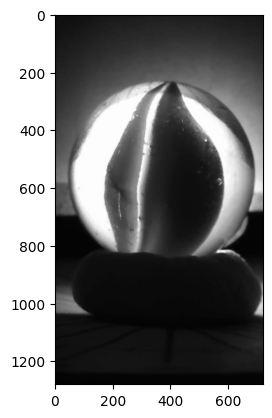

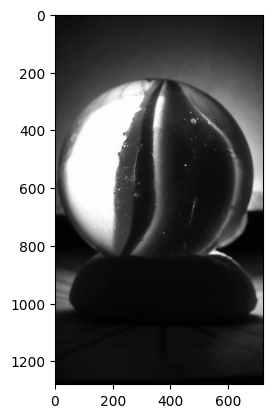

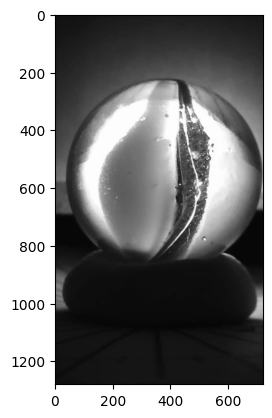

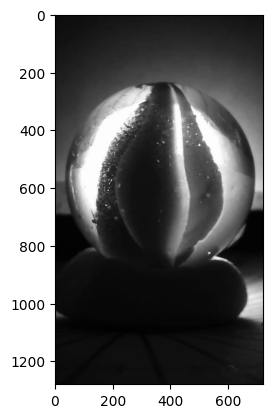

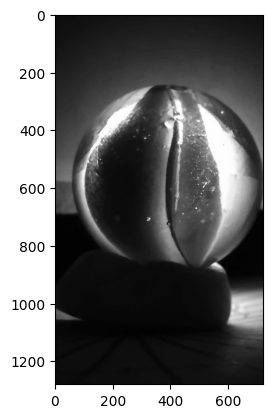

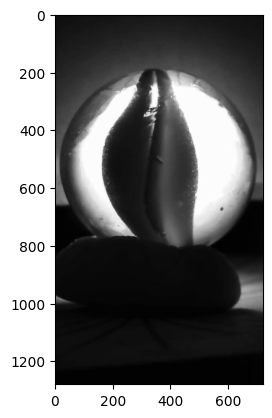

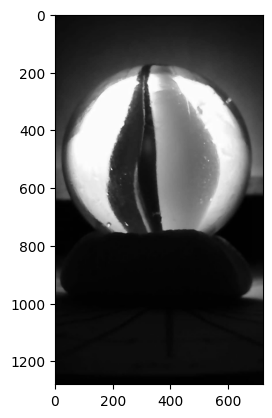

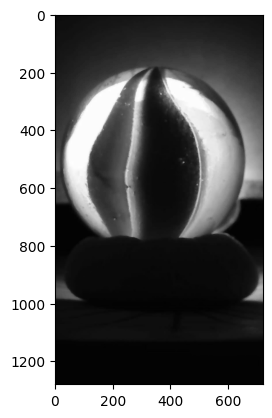

In [5]:
# Display each image with a pause
for i in range(0, nproj, 10):
    plt.imshow(data_in[:, :, i], cmap='gray')
    plt.axis('image')
    plt.show()


Crop image

In [6]:
data = data_in[150:900, ...]
nrows, ncols, nproj = data.shape


Display cropped projections

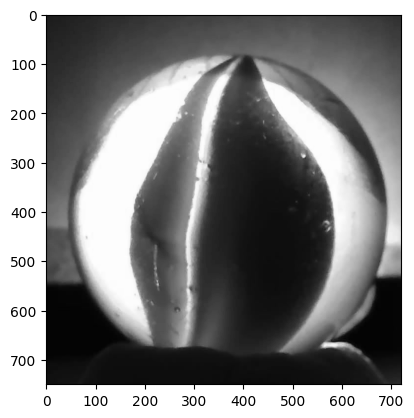

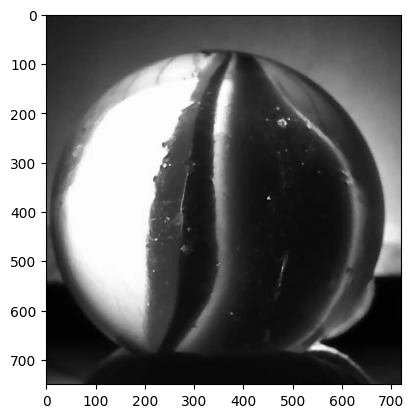

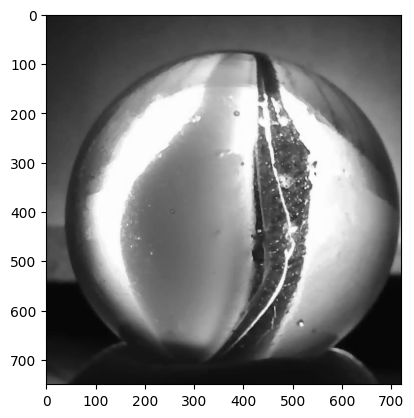

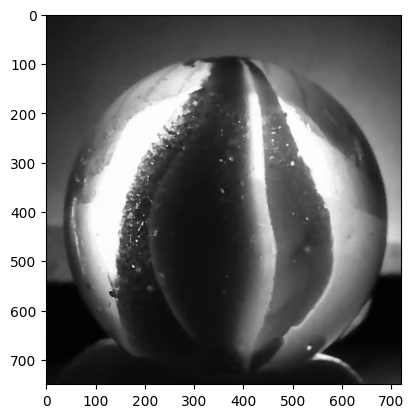

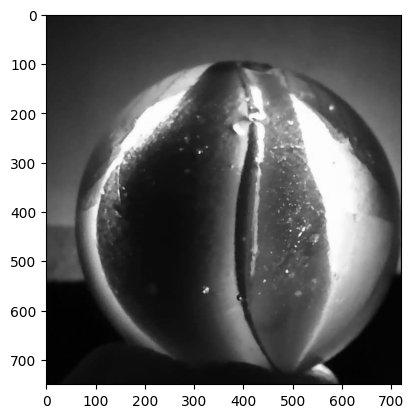

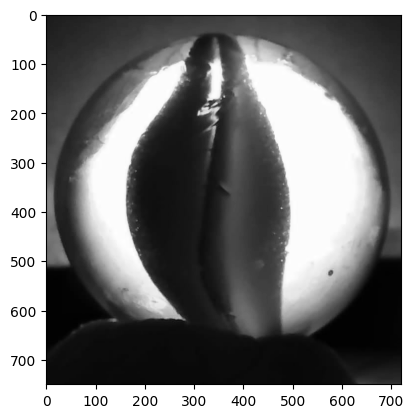

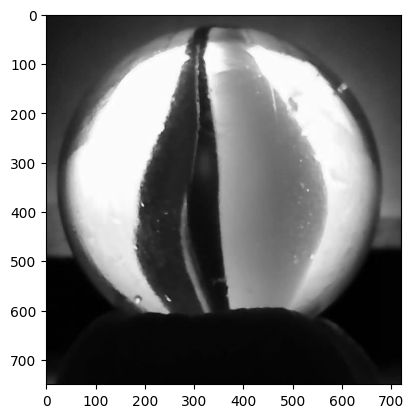

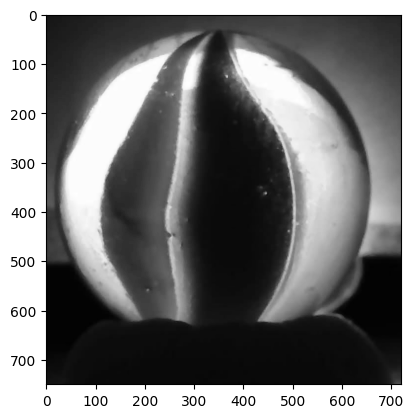

In [7]:
for i in range(0, nproj, 10):
    plt.imshow(data[:, :, i], cmap='gray')
    plt.axis('image')
    plt.show()

Create a gif of all projection

In [ ]:
# Specify the output file name
filename = 'Marble_72proj.gif'

# Create a list to store images
images = []

# Iterate over each projection and add it to the list
for i in range(nproj):
    images.append(Image.fromarray(data[:, :, i]))

# Write images to a gif file
images[0].save(filename, save_all=True, append_images=images[1:], duration=600, loop=0)

# Display the paths
print(f"GIF created: {filename}")

GIF created: Marble_72proj.gif


Alternative - Create a video of all projections

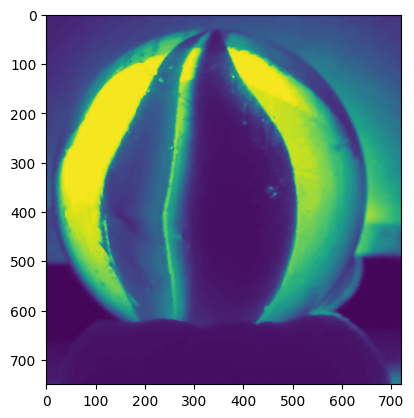

In [ ]:
import matplotlib.animation as animation
fig = plt.figure()
frames = [[plt.imshow(data[:, :, i])] for i in range(nproj)]
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat_delay=1000)
ani.save('Marble_72proj.mp4', writer='ffmpeg')

# IMAGE RECONSTRUCTION
Sinogram

Images have dimensions `rows * columns * number of projection`

Diplay sinogram of the middle slice

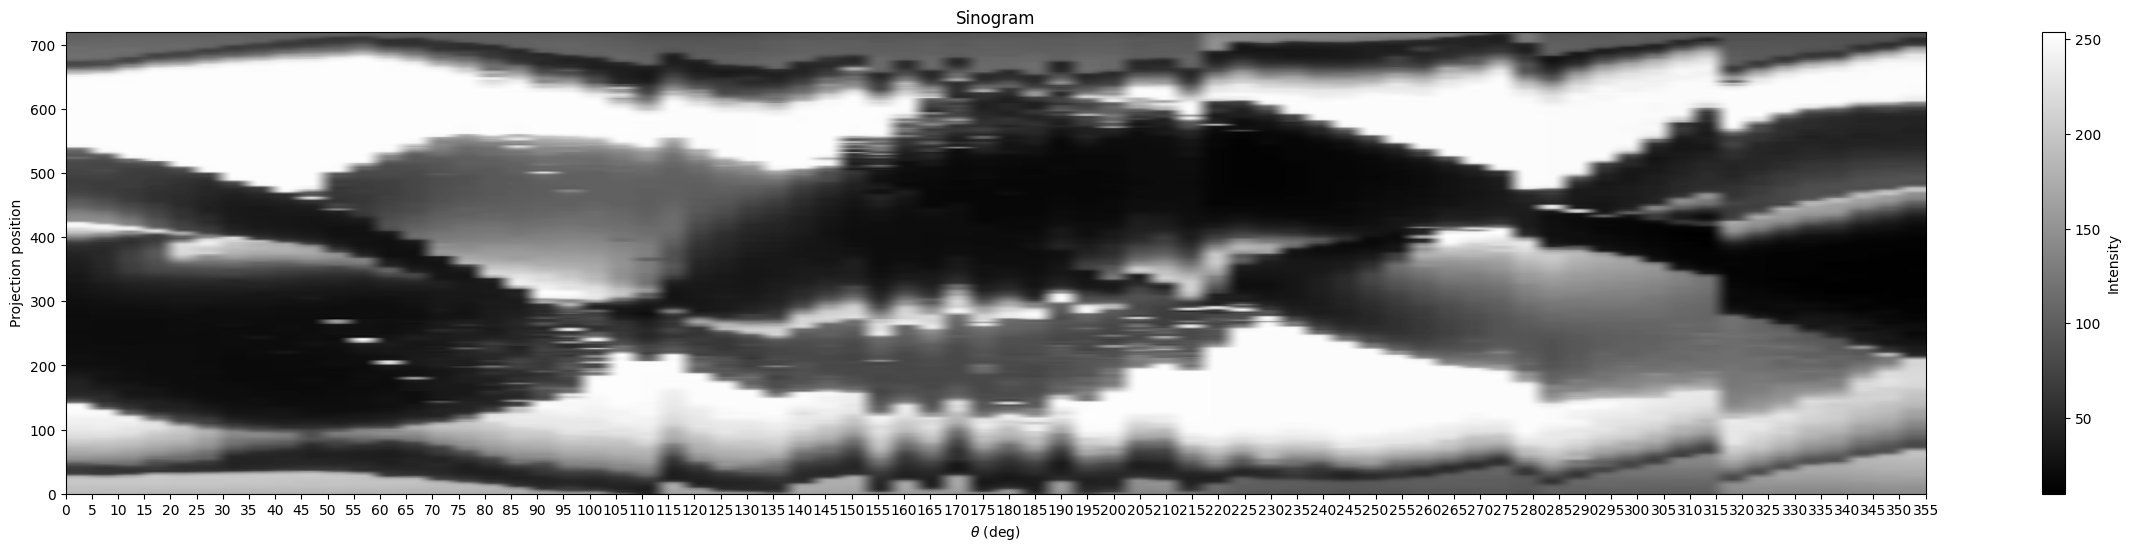

In [9]:
# Specify the slice number to extract the sinogram (e.g., middle slice)
slice_number = nrows // 2
sinogram = data[slice_number, :, :]

# Acquisition angles
angles = np.arange(0, 360, 5)  # from 0 to 355 degrees in steps of 5

# Display the sinogram
plt.figure(figsize=(30, 6))
plt.imshow(sinogram, aspect='auto', cmap='gray', extent=[angles[0], angles[-1], 0, sinogram.shape[0]])
plt.title('Sinogram')
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel('Projection position')
plt.xticks(angles)
plt.colorbar(label='Intensity')
plt.show()

In [12]:
np.amin(sinogram), np.amax(sinogram), type(sinogram), sinogram.dtype

(10, 254, numpy.ndarray, dtype('uint8'))

Filtered backprojection - test reconstruction parameters before 3D reconstruction

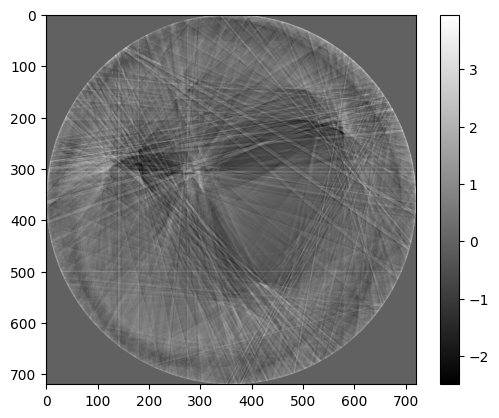

In [13]:
RT = iradon(sinogram, theta=angles, filter_name='ramp', circle=True)
# Display the reconstructed image
plt.figure()
plt.imshow(RT, cmap='gray', aspect='auto')
plt.axis('image')  # Ensure the aspect ratio is equal
plt.colorbar()
plt.show()

In [15]:
RT.dtype, np.amin(RT), np.amax(RT)

(dtype('float64'), -2.4874368432020972, 3.9478326122150924)

interpolate to generate the remaining angles - helps remove streaking artefacts when we don't have enough projections to generate an artefact free reconstruction

this should help viewing the 3D volume

*Note: this step can be avoided by acquiring at least 360 projections (prefered method)*

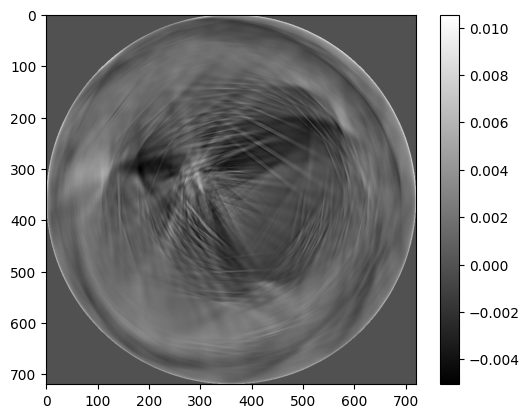

In [ ]:
# Define the angles for the Radon transform
iangles = np.arange(0, 360, 0.5)  # Angles from 0 to 359.5 degrees with step 0.5

# Resize the sinogram to match the new length of angles
isinogram = resize(sinogram, (ncols, len(iangles)), mode='reflect', anti_aliasing=True)

# Perform the inverse Radon transform
iRT = iradon(isinogram, theta=iangles, filter_name='ramp', circle=True)

plt.imshow(iRT, cmap='gray', aspect='auto')
plt.axis('image')  # Ensure the aspect ratio is equal
plt.colorbar()
plt.show()

# **3D reconstruction - 72 projections (Note: acquire at least 360 projections)**

*this can take some time...*

In [16]:
from tqdm import tqdm

angles = np.arange(0, 360, 5)  # Angles from 0 to 355 degrees with step 5
# angles = np.arange(360)  # Uncomment for 360 projections

# Assuming you have a 3D data array `data` where data.shape = (num_slices, num_rows, num_cols)
# Example initialization of data (replace with your actual data loading process)

num_slices = data.shape[0]
ncols = data.shape[1]  # Number of columns in each sinogram (assuming it's the same for all)

# Initialize a 3D array to store the reconstructed slices
Marble3D = np.zeros([ncols, ncols, num_slices], dtype=np.int16)

# Iterate over each slice in the 3D data
for i in tqdm(range(num_slices)):
    sinogram = data[i, :, :]
    reconstructed_slice = iradon(sinogram, theta=angles, filter_name='ramp', circle=True)
    Marble3D[:, :, i] = reconstructed_slice

100%|██████████| 750/750 [09:04<00:00,  1.38it/s]


In [17]:
import sys
sys.getsizeof(Marble3D)

777600144

save Marble3D to nii file to reuse

In [18]:
import nibabel as nib
# Create a NIfTI image from the NumPy array
nii_image = nib.Nifti1Image(Marble3D, affine=np.eye(4))

# Save the NIfTI image to a file
nib.save(nii_image, 'Marble3D.nii.gz')

In [19]:
!pip install k3d
!jupyter nbextension install --py --user k3d
!jupyter nbextension enable --py --user k3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.0 MB/s eta 0:00:00
Installing /usr/local/lib/python3.10/dist-packages/k3d/static -> k3d
Making directory: /root/.local/share/jupyter/nbextensions/k3d/
Copying: /usr/local/lib/python3.10/dist-packages/k3d/static/snapshot_inline.txt -> /root/.local/share/jupyter/nbextensions/k3d/snapshot_inline.txt
Copying: /usr/local/lib/python3.10/dist-packages/k3d/static/standalone.js.map -> /root/.local/share/jupyter/nbextensions/k3d/standalone.js.map
Copying: /usr/local/lib/python3.10/dist-packages/k3d/static/fflate.js -> /root/.local/share/jupyter/nbextensions/k3d/fflate.js
Copying: /usr/local/lib/python3.10/dist-packages/k3d/static/index.js -> /root/.local/share/jupyter/nbextensions/k3d/index.js
Copying: /usr/local/lib/python3.10/dist-packages/k3d/static/extension.js -> /root/.local/share/jupyter/nbextensions/k3d/extension.js
Copying: /usr/local/lib/python3.1

In [20]:
import k3d
from google.colab import output

output.enable_custom_widget_manager()

k3d.switch_to_text_protocol()

In [22]:
plt_volume = k3d.volume(Marble3D)

plot = k3d.plot()
plot += plt_volume
plot.display()

/usr/local/lib/python3.10/dist-packages/k3d/objects.py:1354: UserWarning: wrong dtype: int16 ([<class 'numpy.float16'>, <class 'numpy.float32'>] required)
  warnings.warn("wrong dtype: %s (%s required)" % (actual, required))


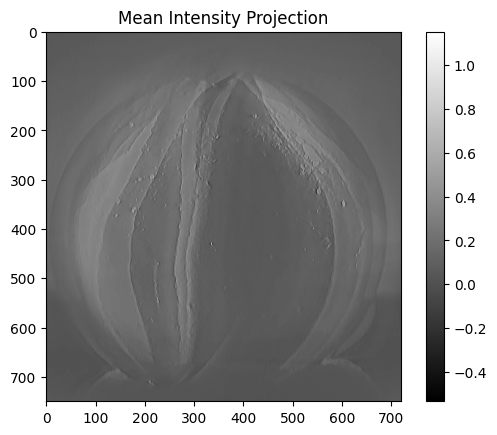

In [ ]:
# Calculate the mean intensity projection
mean_projection = np.mean(Marble3D, axis=0)

# Permute and squeeze to match MATLAB's permute and squeeze operations
mean_projection = np.transpose(mean_projection)

# Display the mean intensity projection using matplotlib
plt.figure()
plt.imshow(mean_projection, cmap='gray')
plt.axis('image')
plt.title('Mean Intensity Projection')
plt.colorbar()
plt.show()

In [ ]:
from skimage import exposure
import nibabel as nib
Marble3D = nib.load("Marble3D.nii.gz").get_fdata()
# Normalize the 3D array to the range [0, 1] equivalent to mat2gray in MATLAB
Marble3D_normalized = exposure.rescale_intensity(Marble3D, out_range=(0, 1))
# Scale the normalized data to the range [0, 256]
Marble3D_Final = Marble3D_normalized * 256
del Marble3D_normalized
# Create a negative image
Marble3D_FinalN = 255 - Marble3D_Final
del Marble3D_Final

In [ ]:
from ipywidgets import interact

# Function to update the plot
def view_slice(slice_index):
    fig = plt.imshow(Marble3D_FinalN[:, :, slice_index], cmap='gray', aspect='auto')
    plt.show()

# Interactive widget to select slice
interact(view_slice, slice_index=(0, Marble3D_FinalN.shape[2] - 1))

interactive(children=(IntSlider(value=374, description='slice_index', max=749), Output()), _dom_classes=('widg…

<function __main__.view_slice(slice_index)>

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact

# Function to update the plot
def view_slice(slice_index):
    fig = plt.imshow(Marble3D[:, :, slice_index], cmap='gray', aspect='auto')
    plt.show()

# Interactive widget to select slice
interact(view_slice, slice_index=(0, Marble3D.shape[2] - 1))

interactive(children=(IntSlider(value=374, description='slice_index', max=749), Output()), _dom_classes=('widg…

<function __main__.view_slice(slice_index)>

**Maximum Intensity Projection (MIP)** - is a commum volume rendering technique that is used to extract high-intensity structures from volumetric data

Each projected pixel contains the maximum value of all pixels of same 2D coordinates in the original data.

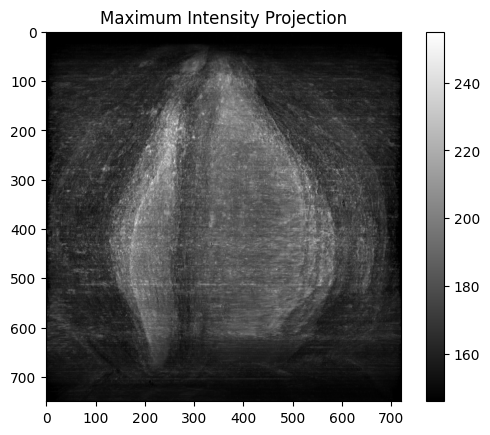

In [ ]:
# Permute the 3D array to match MATLAB's permute operation
Marble3D_permuted = np.transpose(Marble3D_FinalN, (2, 1, 0))
# Calculate dimensions
rows, columns, num_slices = Marble3D_permuted.shape

# Initialize MIP array
MIP = np.zeros((rows, columns), dtype=Marble3D_permuted.dtype)

# Compute Maximum Intensity Projection (MIP)
for col in range(columns):
    for row in range(rows):
        z = Marble3D_permuted[row, col, :]
        maxValue = np.max(z)
        MIP[row, col] = maxValue

# Display MIP using matplotlib
plt.figure()
plt.imshow(MIP, cmap='gray')
plt.title('Maximum Intensity Projection')
plt.axis('image')
plt.colorbar()
plt.show()

**Mean Intensity Projection**

Instead of the maximum above, each projected pixel holds the average value

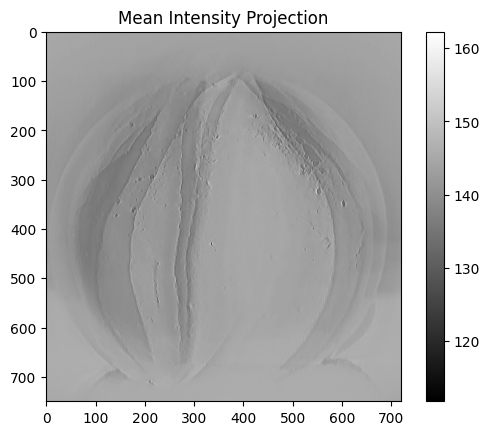

In [ ]:
# Initialize MeIP array
MeIP = np.zeros((rows, columns), dtype=Marble3D_permuted.dtype)

# Compute Mean Intensity Projection (MeIP)
for col in range(columns):
    for row in range(rows):
        z = Marble3D_permuted[row, col, :]
        meanValue = np.mean(z)
        MeIP[row, col] = meanValue

# Display MeIP using matplotlib
plt.figure()
plt.imshow(MeIP, cmap='gray')
plt.title('Mean Intensity Projection')
plt.axis('image')
plt.colorbar()
plt.show()

# 3D reconstruction of interpolated data

this can take a lot of time...




In [ ]:
from skimage.transform import resize
# Example parameters (replace with your actual data)
iangles = np.arange(0, 360, 0.5)  # Angles from 0 to 359.5 degrees with step 0.5

num_slices = data.shape[0]
ncols = data.shape[1]  # Number of columns in each sinogram (assuming it's the same for all)

# Initialize a 3D array to store the reconstructed slices
iMarble3D = np.zeros([ncols, ncols, num_slices])
# Resize the data to match the new length of angles
idata = resize(data, (num_slices, nrows, len(iangles)), anti_aliasing=True)

# Initialize a 3D array to store the reconstructed slices
iMarble3D = np.zeros((num_slices, nrows, nrows))

# Iterate over each slice in the 3D data
for i in tqdm(range(num_slices), desc='Processing slices'):  # tqdm for progress bar
    isinogram = idata[i, :, :]

    reconstructed_slice = iradon(isinogram, theta=iangles, filter_name='ramp', circle=True)
    iMarble3D[:, :, i] = reconstructed_slice

# Mean intensity projection
mean_projection = np.mean(iMarble3D, axis=2)

# Display the mean intensity projection
plt.figure()
plt.imshow(np.rot90(mean_projection), cmap='hot')
plt.axis('image')
plt.colorbar()
plt.title('Mean Intensity Projection')
plt.show()

Processing slices:   3%|▎         | 26/750 [03:02<1:24:43,  7.02s/it]


KeyboardInterrupt: 